In [1]:
rm(list = ls())
suppressPackageStartupMessages({
    library(Seurat)
    library(dplyr)
    library(ggplot2)
    library(ggrepel)
    library(clusterProfiler)
    library(org.Mm.eg.db)
    library(msigdbr)
    library(writexl)
    library(tidyr)
})

library(future)
plan("multicore", workers = 54)
options(future.globals.maxSize = Inf)
set.seed(1234)

seu <- readRDS("/data3/Group8/gonglihao/1-MMP9/5-sub/Mono-Mac+Mac+DC-Annotation.rds")
# 提取Pro-inflammatory recruited Mac细胞
target_cells <- subset(seu, 
                      celltype == "Pro-inflammatory recruited Mac" & 
                      orig.ident %in% c("shmmp9-1", "shNC"))

# 设置分组标识（假设orig.ident直接对应实验条件）
Idents(target_cells) <- "orig.ident"
# 使用之前定义的差异分析函数
deg_result <- FindMarkers(
  target_cells,
  ident.1 = "shmmp9-1",
  ident.2 = "shNC",
  min.pct = 0.25,       # 可调整至0.1以捕获更多基因
  logfc.threshold = 0.25,
  test.use = "wilcox"
)

# 添加基因名和差异表达标签
deg_result$gene <- rownames(deg_result)
deg_result <- deg_result %>%
  mutate(
    expression_level = case_when(
      avg_log2FC >= 0.5 & p_val_adj <= 0.05 ~ "Upregulated",
      avg_log2FC <= -0.5 & p_val_adj <= 0.05 ~ "Downregulated",
      TRUE ~ "Not significant"
    )
  )
up_genes <- deg_result %>% 
  filter(expression_level == "Upregulated") %>% 
  pull(gene)

down_genes <- deg_result %>% 
  filter(expression_level == "Downregulated") %>% 
  pull(gene)
run_go_analysis <- function(genes, direction) {
  if (length(genes) < 5) {
    warning(paste0(direction, "基因数量不足（<5），跳过GO分析"))
    return(NULL)
  }
  
  # 转换Entrez ID
  entrez_ids <- bitr(genes, 
                    fromType = "SYMBOL",
                    toType = "ENTREZID",
                    OrgDb = org.Mm.eg.db,
                    drop = TRUE)$ENTREZID
  
  # GO富集分析（Biological Process）
  ego <- enrichGO(
    gene = entrez_ids,
    OrgDb = org.Mm.eg.db,
    keyType = "ENTREZID",
    ont = "BP",  # 仅分析生物过程
    pAdjustMethod = "BH",
    pvalueCutoff = 0.05,
    qvalueCutoff = 0.2,
    readable = TRUE
  )
  
  return(ego)
}

# 运行分析
go_up <- run_go_analysis(up_genes, "Upregulated")
go_down <- run_go_analysis(down_genes, "Downregulated")
library(stringr)

plot_go <- function(ego, title) {
  if (is.null(ego)) return(NULL)
  
  dotplot(ego, showCategory=15, font.size=10) + 
    ggtitle(title) +
    scale_y_discrete(labels=function(x) str_wrap(x, width=40)) +  # 换行显示长名称
    theme(plot.title = element_text(face="bold", size=12))
}

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(genes, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Mm.eg.db, :
“28.57% of input gene IDs are fail to map...”


'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(genes, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Mm.eg.db, :
“28.57% of input gene IDs are fail to map...”
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


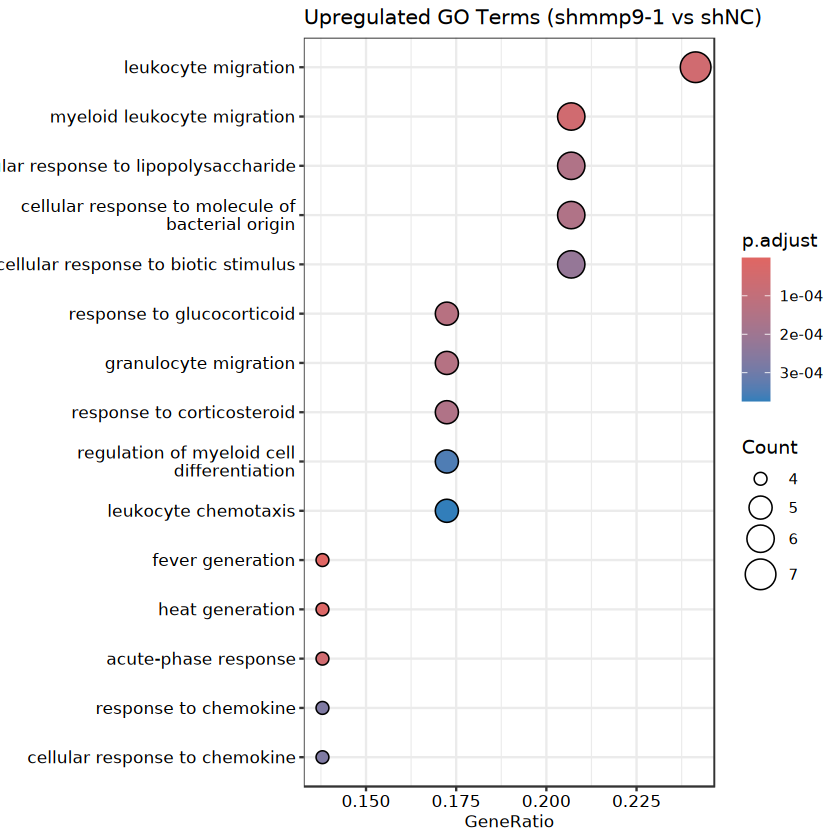

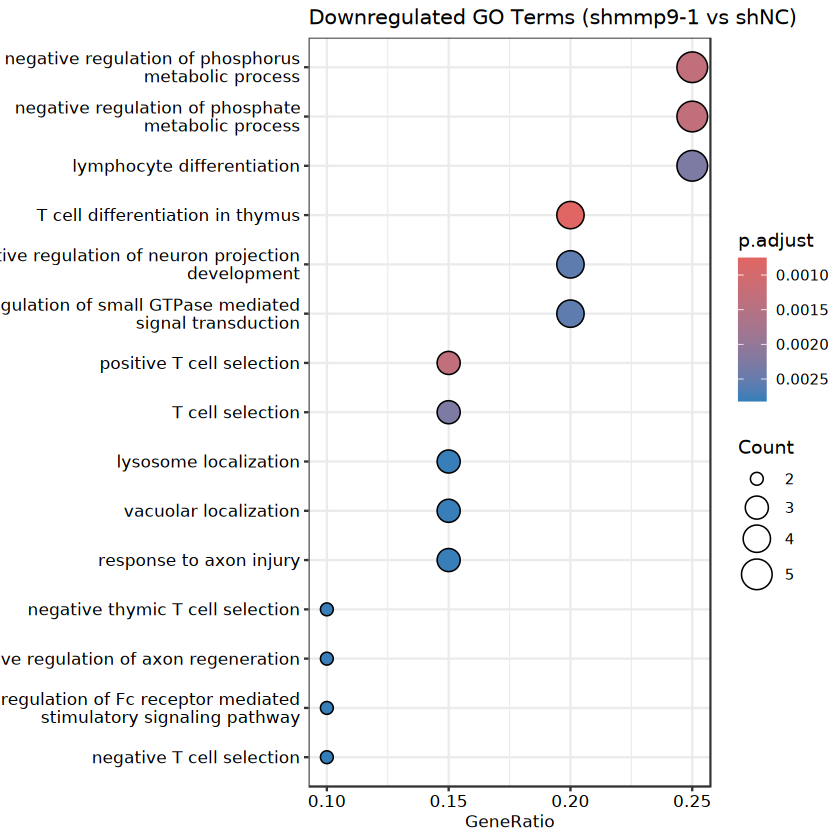

In [ ]:
plot_go(go_up, "Upregulated GO Terms (shmmp9-1 vs shNC)")
plot_go(go_down, "Downregulated GO Terms (shmmp9-1 vs shNC)")
write_xlsx(
  list(
    DEGs = deg_result,
    GO_Upregulated = as.data.frame(go_up),
    GO_Downregulated = as.data.frame(go_down)
  ),
  "/data3/Group8/gonglihao/1-MMP9/5-sub/Pro-inflammatory_Mac_DEG_GO.xlsx"
)

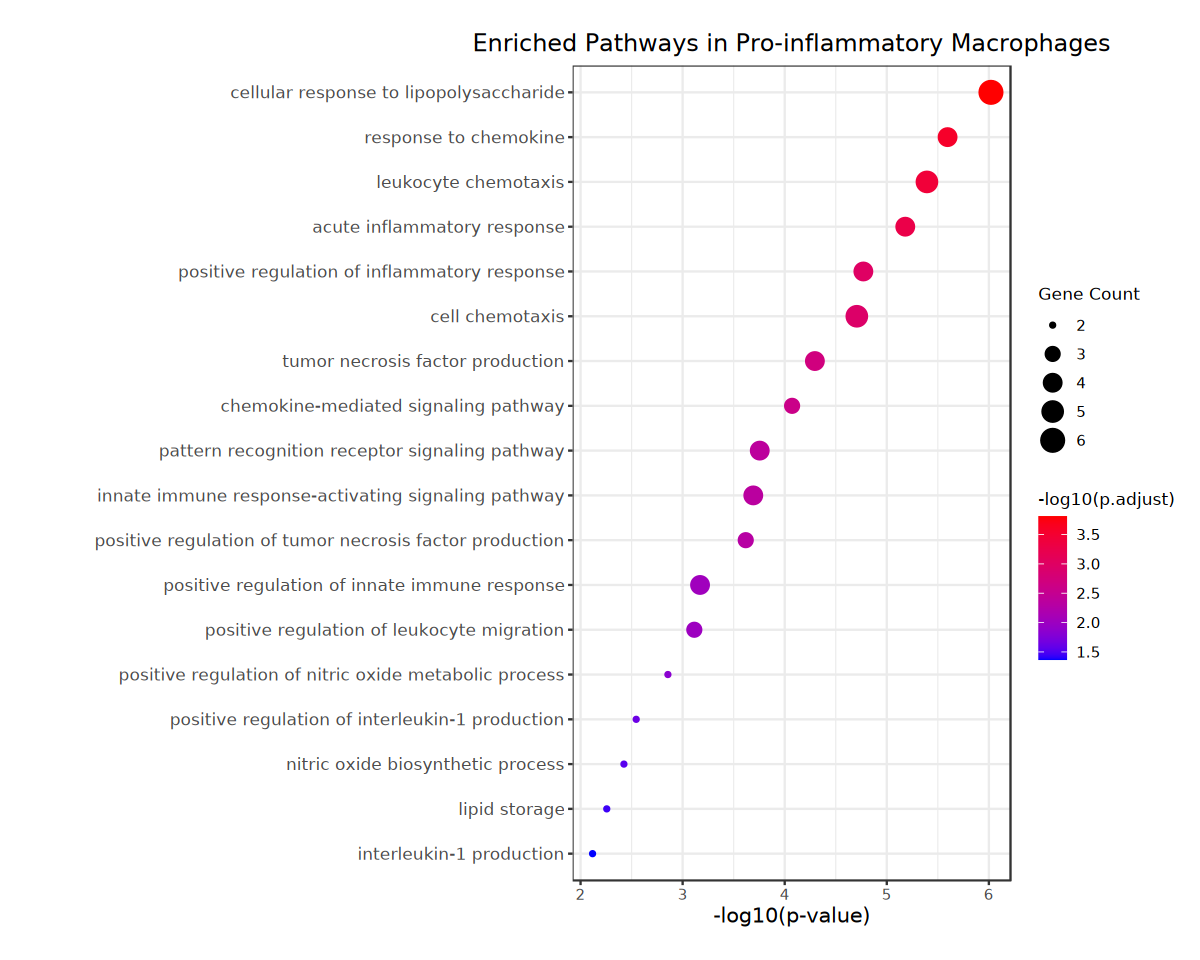

In [9]:
# 首先，创建您感兴趣的通路列表
pathways_of_interest <- c(
    "lipid storage",
    "nitric oxide biosynthetic process",
    "positive regulation of nitric oxide metabolic process",
    "positive regulation of inflammatory response",
    "acute inflammatory response",
    "tumor necrosis factor production",
    "positive regulation of tumor necrosis factor production",
    "interleukin-1 production",
    "positive regulation of interleukin-1 production",
    "chemokine-mediated signaling pathway",
    "response to chemokine",
    "positive regulation of leukocyte migration",
    "leukocyte chemotaxis",
    "cell chemotaxis",
    "innate immune response-activating signaling pathway",
    "positive regulation of innate immune response",
    "cellular response to lipopolysaccharide",
    "pattern recognition receptor signaling pathway"
)

# 从go_up结果中筛选这些通路
filtered_go <- go_up[go_up$Description %in% pathways_of_interest,]

# 按p.adjust排序，并将Description转换为factor以保持顺序
filtered_go$Description <- factor(filtered_go$Description, 
                                levels = filtered_go$Description[order(filtered_go$p.adjust, decreasing = TRUE)])

options(repr.plot.width = 10, repr.plot.height = 8)
ggplot(filtered_go, aes(x = -log10(pvalue), y = Description)) +
    geom_point(aes(size = Count, color = -log10(p.adjust))) +
    scale_color_gradient(low = "blue", high = "red") +
    theme_bw() +
    theme(
        axis.text.y = element_text(size = 10, hjust = 1),  # 将y轴标签右对齐
        axis.title = element_text(size = 12),
        axis.title.y = element_blank(),
        legend.title = element_text(size = 10),
        plot.title = element_text(size = 14, hjust = 0.5),
        # 调整左边距，数值可以根据需要调整
        plot.margin = margin(t = 20, r = 20, b = 20, l = 100, unit = "pt")
    ) +
    labs(
        title = "Enriched Pathways in Pro-inflammatory Macrophages",
        x = "-log10(p-value)",
        y = NULL,
        size = "Gene Count",
        color = "-log10(p.adjust)"
    )

# 如果您想要保存图片
#ggsave("pro_inflammatory_mac_pathways.pdf", width = 12, height = 8)

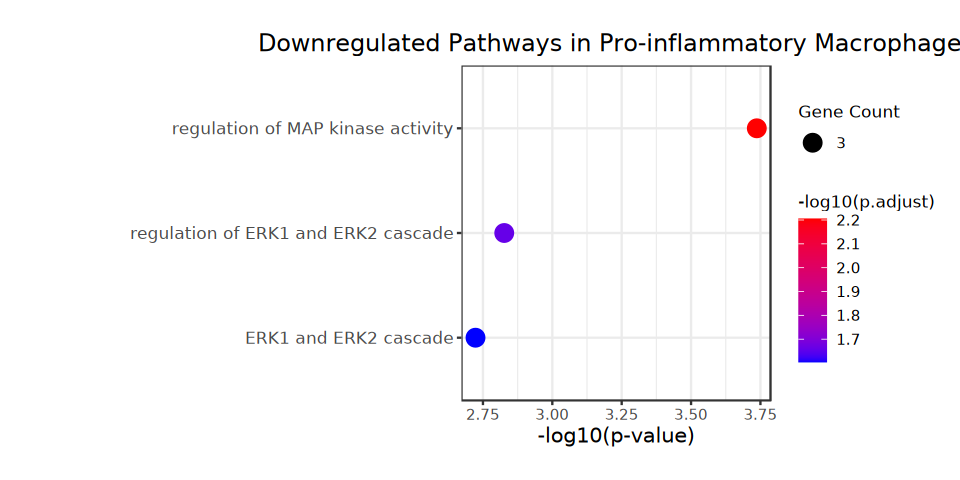

In [16]:
# 定义要展示的下调通路
pathways_of_interest_down <- c(
    # MAPK/ERK相关
    "regulation of MAP kinase activity",
    "ERK1 and ERK2 cascade",
    "regulation of ERK1 and ERK2 cascade"
)

# 从go_down结果中筛选这些通路
filtered_go_down <- go_down[go_down$Description %in% pathways_of_interest_down,]

# 按p.adjust排序，并将Description转换为factor以保持顺序
filtered_go_down$Description <- factor(filtered_go_down$Description, 
                                     levels = filtered_go_down$Description[order(filtered_go_down$p.adjust, decreasing = TRUE)])

options(repr.plot.width = 8, repr.plot.height = 4)
ggplot(filtered_go_down, aes(x = -log10(pvalue), y = Description)) +
    geom_point(aes(size = Count, color = -log10(p.adjust))) +
    scale_color_gradient(low = "blue", high = "red") +
    theme_bw() +
    theme(
        axis.text.y = element_text(size = 10, hjust = 1),
        axis.title = element_text(size = 12),
        axis.title.y = element_blank(),
        legend.title = element_text(size = 10),
        plot.title = element_text(size = 14, hjust = 0.5),
        plot.margin = margin(t = 20, r = 20, b = 20, l = 100, unit = "pt")
    ) +
    labs(
        title = "Downregulated Pathways in Pro-inflammatory Macrophages",
        x = "-log10(p-value)",
        y = NULL,
        size = "Gene Count",
        color = "-log10(p.adjust)"
    )

# 保存图片
#ggsave("pro_inflammatory_mac_down_pathways.pdf", width = 12, height = 8)

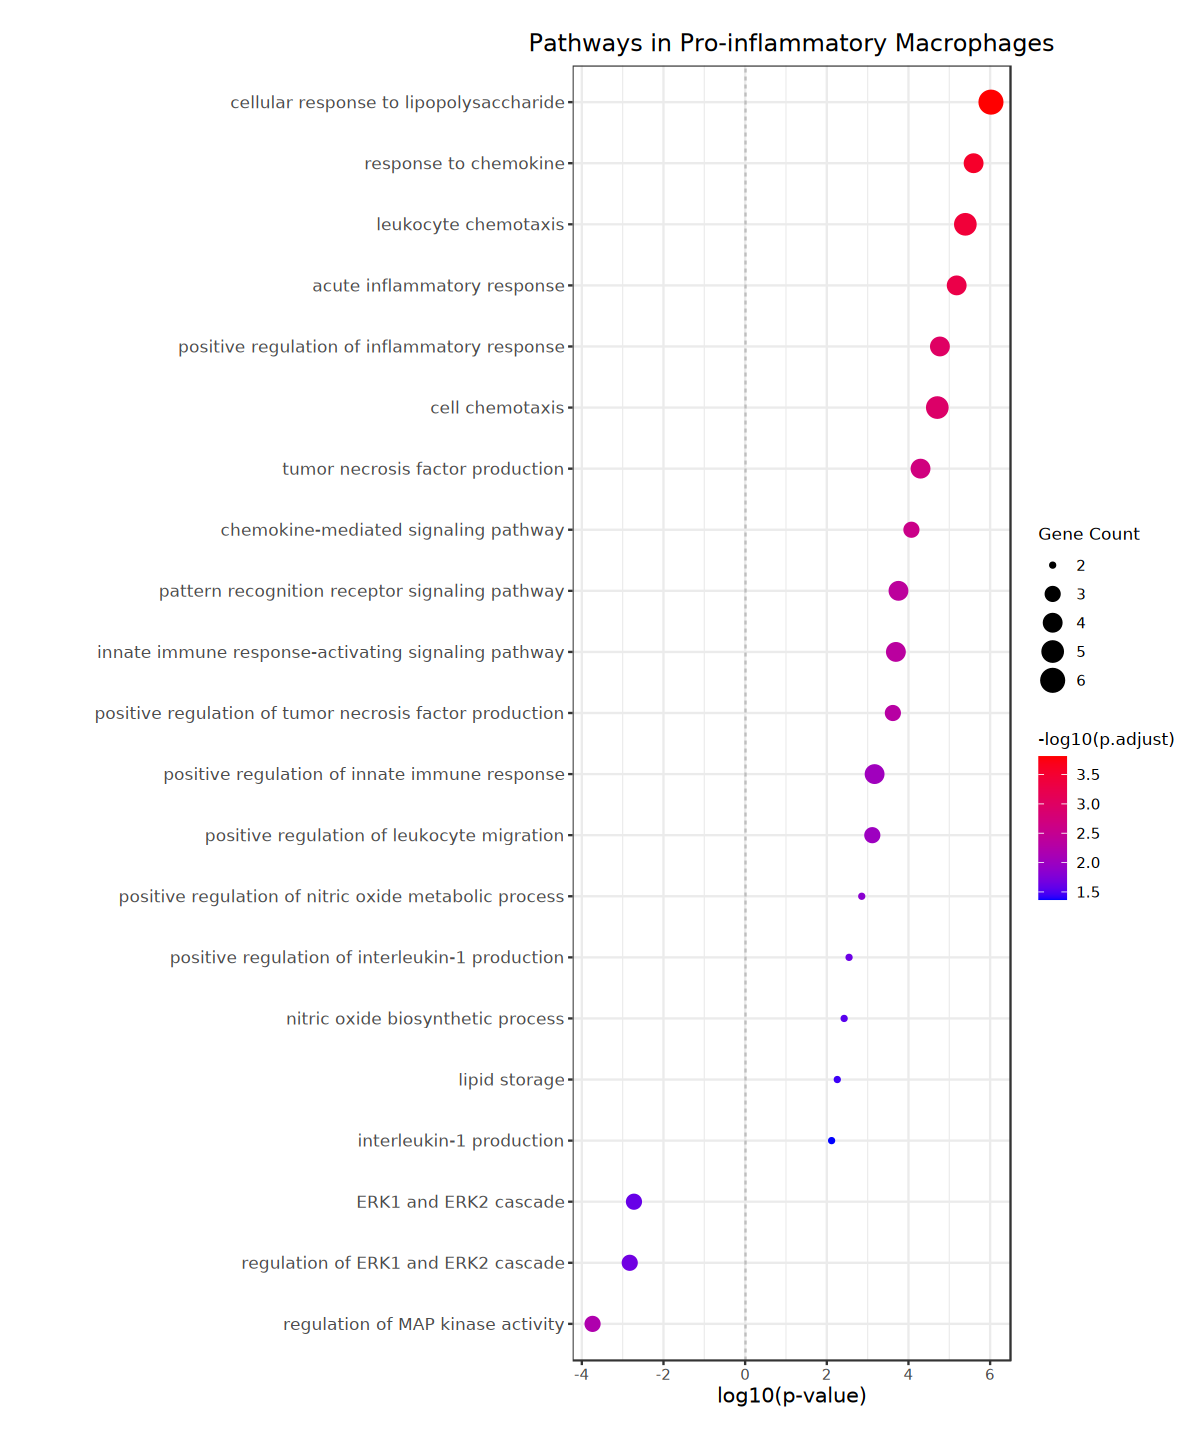

In [20]:
# 分别对上调和下调通路按p值排序（注意reverse顺序）
up_paths <- filtered_go[order(filtered_go$p.adjust),]$Description
down_paths <- filtered_go_down[order(filtered_go_down$p.adjust, decreasing = TRUE),]$Description

# 创建合并并排序的因子水平 - 正值在上
combined_go$Description <- factor(combined_go$Description,
                                levels = c(rev(down_paths), rev(up_paths)))

# 修改绘图代码
ggplot(combined_go, aes(x = log10p, y = Description)) +
    geom_point(aes(size = Count, color = -log10(p.adjust))) +
    scale_color_gradient(low = "blue", high = "red") +
    theme_bw() +
    theme(
        axis.text.y = element_text(size = 10, hjust = 1),
        axis.title = element_text(size = 12),
        axis.title.y = element_blank(),
        legend.title = element_text(size = 10),
        plot.title = element_text(size = 14, hjust = 0.5),
        plot.margin = margin(t = 20, r = 20, b = 20, l = 100, unit = "pt")
    ) +
    labs(
        title = "Pathways in Pro-inflammatory Macrophages",
        x = "log10(p-value)",
        y = NULL,
        size = "Gene Count",
        color = "-log10(p.adjust)"
    ) +
    geom_vline(xintercept = 0, linetype = "dashed", color = "gray")